# Klimakoffer.jl

Klimakoffer.jl is a userfriendly climate package to teach students how to simulate the Earth’s surface temperature depending on CO$_2$ concentration in the atmosphere, the albedo of the surface and many other parameters. The software is written in the programming language Julia.

## Model

The model is based on a two-dimensional energy balance model (EBM) governed by the following parabolic PDE:

\begin{equation}
    C(\hat{r}) \frac{\partial T}{\partial t} + A + B\,T = \nabla (D(\hat{r}) \nabla T) + QS(\hat{r},t) a(\hat{r}).
\end{equation}

In this tutorial we will briefly explain the individual components of the model, show how they are represented in the code and we will start a first simulation on our own.

First of all we need to load the package Klimakoffer as follows

In [1]:
include("../Klimakoffer.jl/src/Klimakoffer.jl");

Since we solve our EBM at each time step on a latitude-longitude mesh, we need to define the number of timesteps (in this case 48 timesteps with each step corresponding to 7.6 days) per astronomical year with:

In [2]:
NT = 48;

and create a mesh with a fixed size of 128 x 65 (longitude x latitude) grid points:

In [3]:
mesh = Klimakoffer.Mesh()

Mesh() with 128×65 degrees of freedom

Next we need to create the model described above with our previously defined number of timesteps (NT) as well as our freshly created mesh (mesh):

In [4]:
model = Klimakoffer.Model(mesh, NT)

Model() with 128×65 degrees of freedom

This newly created model contains all components and parameters we need in order to fully describe our parabolic PDE. Let us briefly examine these components individually. (The following steps do not have to be carried out for the simulation and are for illustration purposes only.)

### Model Components

We start with the effective heat capacity $C(\hat{r})$ which depends on the geography (land, ocean, ice, etc.) and therefore is a function of position $\hat{r}$ represented by a pair of longitude and latitude. For a given geography our model object stores heat capacities as a two-dimensional matrix of 128 rows and 65 columns.

In [5]:
size(model.heat_capacity) # 2D matrix

(128, 65)

Next we take a look at the outgoing longwave radiation (OLR) which the EBM parameterizes by the expression $OLR = A + B\,T$. The parameter $A$ is the outgoing long-wave radiation depending on the CO$_2$ concentration in the atmosphere.

In [6]:
model.radiative_cooling_co2

210.3

The parameter B describes the feedback effects of the outgoing long-wave radiation like water vapor cycles, lapse rate and cloud cover and is a constant scalar:

In [7]:
model.radiative_cooling_feedback

2.15

The next component in our model is the diffusion coefficient $D(\hat{r})$ which transports the heat horizontally by diffusion across isotherms. Since $D$ depends on the sine of latitude, the values of $D$ become smaller near the poles and larger over the equator:

In [8]:
size(model.diffusion_coeff) # 2D matrix

(128, 65)

A very important parameter is the albedo coefficient $a(\hat{r})$ which gives the ratio of outgoing diffusive reflection of solar radiation to the total solar radiation coming in from space. The albedo parameter depends on the surface conditions resp. geography (ocean, land mass, sea ice, snow, etc.).

In [9]:
size(model.albedo) # 2D matrix

(128, 65)

Let's move to the last part of our model. Here we got three different parameters describing the solar insolation on earth. The first parameter $Q$ is the solar constant divided by four (since the earth is rotating resp. averaged day-night cycle) with a value of about $342 \frac{W}{m^2}$. The second parameter $S(\hat{r},t)$ is the seasonal and latitudinal distribution of solar insolation which depends on the orbit of the earth around the sun (orbital parameters). Since we resolve a year in 48 timesteps we need 48 solar forcing matrizes:

In [10]:
size(model.solar_forcing) # 3D matrix

(128, 65, 48)

To get a better idea on how the solar forcing acts on the earth over the year we make an ainimated 2D plot. Note that our "simulation year" begins on March 21.

WebIO._IJuliaInit()

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


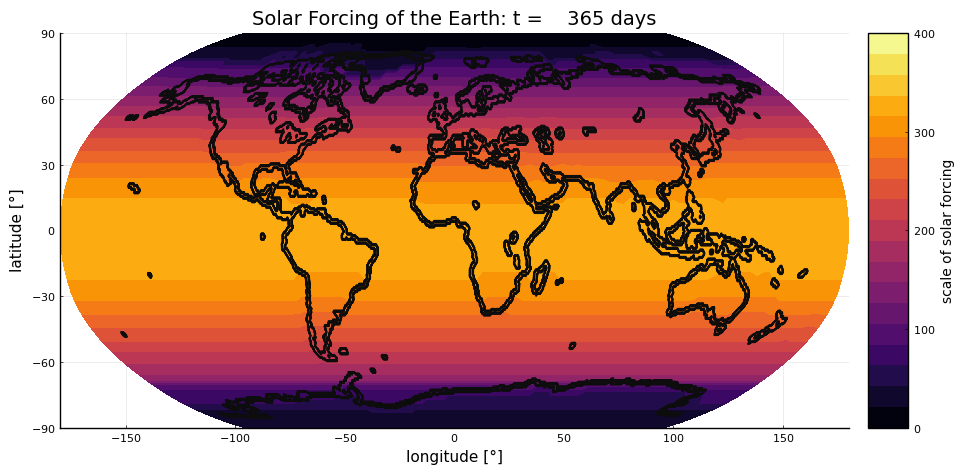

┌ Info: Saved animation to 
│   fn = /mnt/western_digital/workbench/julia/Klimakoffer/sandbox/solar_forcing.gif
└ @ Plots /home/jmark/.julia/packages/Plots/S30zV/src/animation.jl:114


Plots.AnimatedGif("/mnt/western_digital/workbench/julia/Klimakoffer/sandbox/solar_forcing.gif")
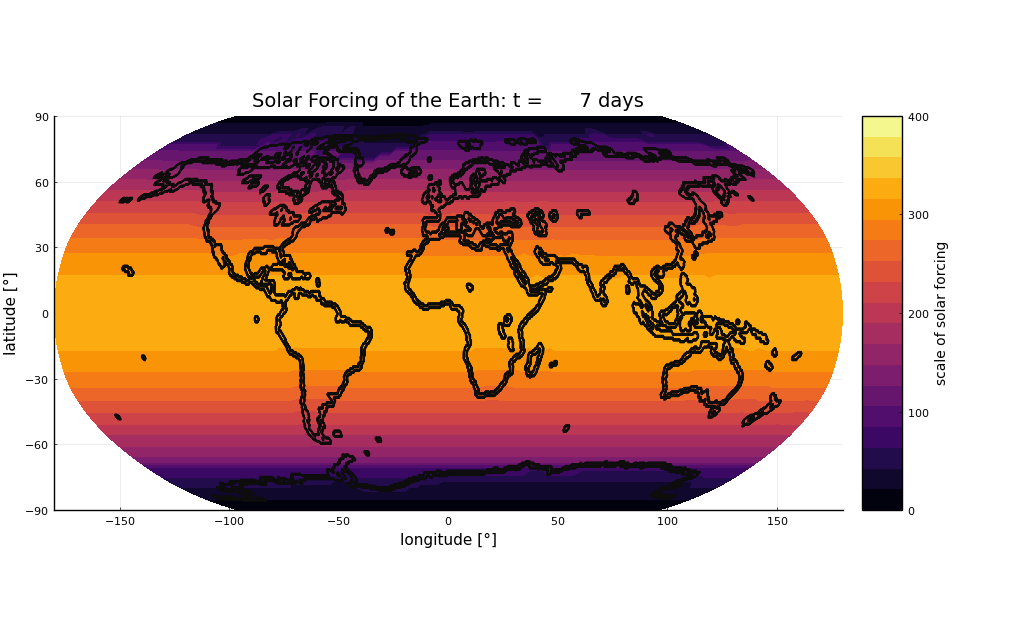

In [11]:
using Plots
using Interact

pyplot();

# Read in the outline of the continents.
outline = Klimakoffer.read_geography("../Klimakoffer.jl/The_World_Outline_high_res.dat",800,246);

xol,yol,zol = Klimakoffer.apply_richardson_projection(outline);
x,y,z = Klimakoffer.apply_richardson_projection(model.solar_forcing[:,:,1]);

anim = @animate for t in 1:size(model.solar_forcing,3)

    title = "Solar Forcing of the Earth: t = " * lpad(string(Int(floor(t*365/48))), 6, ' ') * " days";

    data = model.solar_forcing[:,:,t];
    z = reverse(reverse(data),dims=1);
    contourf(x,y,z,
        clims=(0,400),
        levels=LinRange(0,400,20),
        aspect_ratio=1.0,
        title=title,
        xlabel="longitude [°]",
        ylabel="latitude [°]",
        colorbar_title="scale of solar forcing",
        size=(1024,640));
    
    contour!(xol,yol,zol,c=:grays);
    
end;

gif(anim, "solar_forcing.gif", fps = 7)

## Running our Simulation

Now, that we have examined the model parameters, we can combine everything into a discretization object

In [12]:
disc = Klimakoffer.Discretization(mesh, model, NT)

Discretization() with 128×65 degrees of freedom

and can directly simulate our first scenario!

In [13]:
global_mean_temp = Klimakoffer.compute_equilibrium!(disc)

year  Average Temperature
0  5.000000000000189
1  9.004451135208702
2  9.794803974040475
3  10.891438923925676
4  11.79096403728964
5  12.481170727333
6  12.999085878123026
7  13.384303292307024
8  13.669812313384503
9  13.881159781388783
10  14.037575162852304
11  14.153361080313717
12  14.239103641568073
13  14.302624697079011
14  14.34970202194895
15  14.384604941756214
16  14.410489957304387
17  14.42969225837077
18  14.443940447343444
19  14.454514784995974
20  14.462363914213471
21  14.468191036721372
22  14.472517593123952
23  14.47573035613432
24  14.478116281193508
25  14.479888312228105
26  14.481204499489488
27  14.482182168723396
28  14.482908426404672
29  14.483447950855966
30  14.483848771972426
31  14.484146559784065
32  14.484367807186345
33  14.48453219237827
34  14.484654332676435
35  14.484745086665873
36  14.484812521111543
37  14.484862629006656
38  14.484899862855327
39  14.484927530762121
40  14.484948090642092
41  14.484963368769018
EQUILIBRIUM REACHED!


14.484963368769018

Get the surface temperature distributions for a simulated year.

In [14]:
temperatures = reshape(disc.annual_temperature,(128,65,NT));

Finally, we plot our simulated temperatur distribution on the earth and create a little video along the way. This may take a little time.

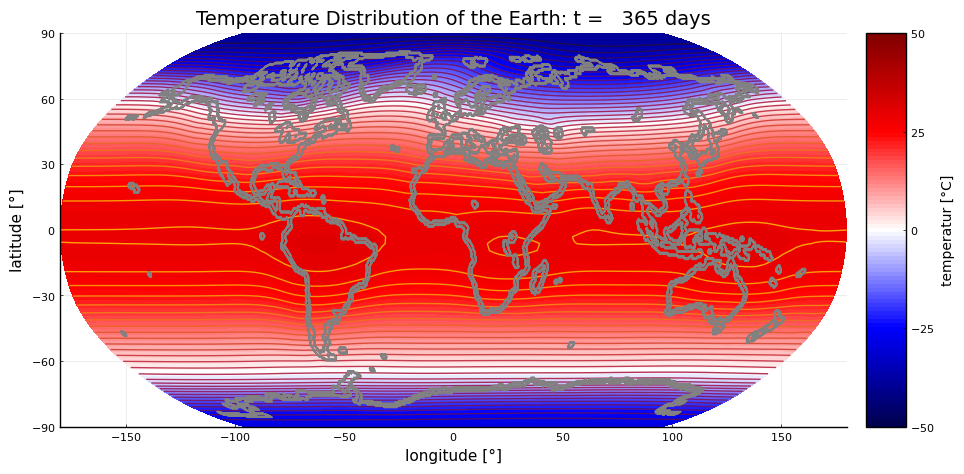

┌ Info: Saved animation to 
│   fn = /mnt/western_digital/workbench/julia/Klimakoffer/sandbox/temp.gif
└ @ Plots /home/jmark/.julia/packages/Plots/S30zV/src/animation.jl:114


Plots.AnimatedGif("/mnt/western_digital/workbench/julia/Klimakoffer/sandbox/temp.gif")
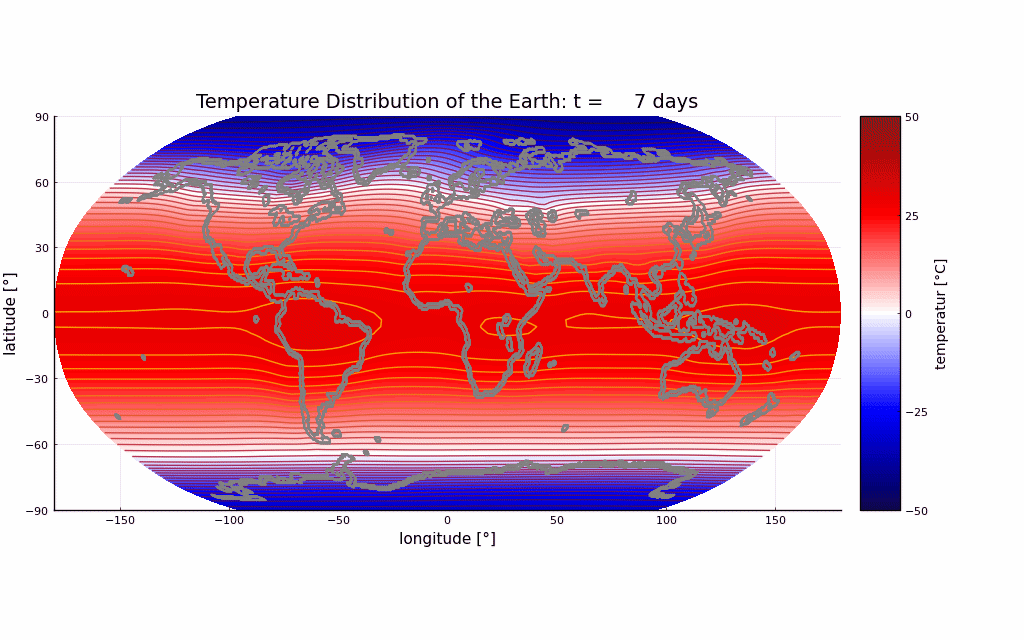

In [15]:
# Read in the outline of the continents.
outline = Klimakoffer.read_geography("../Klimakoffer.jl/The_World_Outline_high_res.dat",800,246);

xol,yol,zol = Klimakoffer.apply_richardson_projection(outline);
x,y,z = Klimakoffer.apply_richardson_projection(temperatures[:,:,1]);

cmin = -50
cmax =  50

levels = LinRange(cmin,cmax,100);

anim = @animate for t in 1:size(temperatures,3)

    title = "Temperature Distribution of the Earth: t = "
    title *= lpad(string(Int(floor(t*365/48))), 5, ' ') * " days"

    data = temperatures[:,:,t]

    levels = LinRange(cmin,cmax,100)
    
    z = reverse(reverse(data),dims=1)
    contourf(x,y,z,
        clims=(cmin,cmax),
        levels=levels,
        aspect_ratio=1.0,
        title=title,
        xlabel="longitude [°]",
        ylabel="latitude [°]",
        c=:seismic,
        colorbar_title="temperatur [°C]",
        size=(1024,640));
    
    levels = LinRange(cmin,cmax,50);

    contour!(x,y,z,
        clims=(cmin,cmax),
        levels=levels);
    
     contour!(xol,yol,zol,c=:grays);
    
end;

gif(anim, "temp.gif", fps = 7)